# Parameter Tuning 

In [1]:
import random
import gc 
import datetime as dt
import numpy as np 
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV

%matplotlib inline

/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Data and Weight Parameters

In [2]:
prop = pd.read_csv('../input/properties_2016.csv')
train = pd.read_csv('../input/train_2016_v2.csv')

# Weight parameters
XGB_WEIGHT = 0.6840
BASELINE_WEIGHT = 0.0056
OLS_WEIGHT = 0.0550
XGB1_WEIGHT = 0.8083
BASELINE_PRED = 0.0115  # mean of training data

/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# LightGBM
* https://www.kaggle.com/sidharthkumar/trying-lightgbm

* https://www.kaggle.com/yuqingxue/lightgbm-85-97

* https://www.kaggle.com/aharless/lightgbm-with-outliers-remaining

* https://www.kaggle.com/jamesdhope/zillow-ensemble-of-regressors-0-065

* https://www.kaggle.com/nikunjm88/creating-additional-features/

In [3]:
'''
data preprocessing for lightgbm
'''
# feature engineering
prop['prop_age'] = 2018 - prop['yearbuilt']  # property age

prop['total_rm_ct'] = prop['bathroomcnt'] + prop['bedroomcnt']  # total bed rm + bathrm
prop['room_size_avg'] = prop['calculatedfinishedsquarefeet'] / prop['roomcnt']
prop['tax_structure_land'] = prop['structuretaxvaluedollarcnt'] - prop['landtaxvaluedollarcnt']
prop['living_area_proportion'] = prop['calculatedfinishedsquarefeet'] / prop['lotsizesquarefeet']
prop['living_area_proportion_2'] = prop['finishedsquarefeet12'] / prop['finishedsquarefeet15']

prop["location"] = prop["latitude"] + prop["longitude"]  # location total
# properties within the zip code
prop['homes_wi_zip'] = prop['regionidzip'].map(prop['regionidzip'].value_counts().to_dict())

# one hot
prop['has_basement'] = prop['basementsqft'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop['has_hottub'] = prop['hashottuborspa'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop['has_pool'] = prop['poolcnt'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop['has_ac'] = prop['airconditioningtypeid'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)

for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)
        
df_train = train.merge(prop, how='left', on='parcelid')

df_train.fillna(df_train.median(), inplace=True)  # fill w/ median val

# drop columns from eda
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc',
                        'propertycountylandusecode', 'fireplacecnt', 'fireplaceflag'], axis=1)

x_train = pd.get_dummies(x_train)  # handle categories

y_train = df_train['logerror'].values  # labels
print('x_train: ' + str(x_train.shape) + '\ny_train: ' + str(y_train.shape))

train_columns = x_train.columns 

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)
    
#del df_train  # memory
gc.collect()
print('\n \nx_train shape: ', x_train.shape)

x_train = x_train.values.astype(np.float32, copy=False)  # np array

x_train: (90275, 65)
y_train: (90275,)

 
x_train shape:  (90275, 65)


In [4]:
# create lightgbm dataset from x and y train values
d_train = lgb.Dataset(x_train, label=y_train)  # lightgbm data model

In [5]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
#df_test = sample.merge(X_test, on='parcelid', how='left')
lgbm_train = lgb.Dataset(X_train, label=y_train)

## LightGBM Grid Search

Successful notes

* colsample_bytree = .75

* n_estimators = 8

* subsample = .7

```
{'boosting_type': 'gbdt', 'colsample_bytree': 0.85, 'learning_rate': 0.01, 'n_estimators': 10, 'num_leaves': 22, 'objective': 'regression', 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.7}
```

In [6]:
params = {}
params['max_bin'] = 10  
params['learning_rate'] = 0.0021  # shrinkage_rate -- try lower
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'  # l1
params['sub_feature'] = 0.5  # feature_fraction
params['bagging_fraction'] = 0.85  # sub_row
params['num_leaves'] = 512  # num_leaf
params['min_data'] = 500  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

gridParams = {
    'learning_rate': [0.01, 0.0019, 0.0021,0.0024],
    'n_estimators': [6, 8, 10],
    'num_leaves': [6,12,16,22],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'seed' : [500],
    'colsample_bytree' : [0.75, 0.8, .85],
    'subsample' : [0.7],
    'reg_alpha' : [1,2,6],
    'reg_lambda' : [1,2,6],
    }

lgbm_clf = lgb.LGBMRegressor(params, lgbm_train, 430)

grid = GridSearchCV(lgbm_clf, gridParams)
grid.fit(X_train, y_train)

print(grid.best_params_)
grid.predict(X_test)
grid.score(X_test,y_test)

{'boosting_type': 'gbdt', 'colsample_bytree': 0.85, 'learning_rate': 0.01, 'n_estimators': 10, 'num_leaves': 22, 'objective': 'regression', 'reg_alpha': 1, 'reg_lambda': 1, 'seed': 500, 'subsample': 0.7}


0.0016358005480702209

In [7]:
# running lightgbm
params = {}
params['max_bin'] = 10  
params['learning_rate'] = 0.0021  # shrinkage_rate
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'mae'  # l1
params['sub_feature'] = 0.5  # feature_fraction
params['bagging_fraction'] = 0.85  # sub_row
params['num_leaves'] = 512  # num_leaf
params['min_data'] = 500  # min_data_in_leaf
params['min_hessian'] = 0.05  # min_sum_hessian_in_leaf
params['verbose'] = 0
params['feature_fraction_seed'] = 2
params['bagging_seed'] = 3

np.random.seed(0)
random.seed(0)

clf = lgb.train(params, lgbm_train, 430)  #clf = lgb.train(params, d_train, 430)

#del d_train; gc.collect()
#del x_train; gc.collect()
'''
sample = pd.read_csv('../submissions/sample_submission.csv')  # sample data sub file
sample['parcelid'] = sample['ParcelId']  # merge w prop data
df_test = sample.merge(prop, on='parcelid', how='left')

del sample, prop; gc.collect()

x_test = df_test[train_columns]  #x_test = X_test[train_columns]  #

del df_test; gc.collect()

for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
    
x_test = x_test.values.astype(np.float32, copy=False)
'''
p_test = clf.predict(X_test)

#del x_test; gc.collect()
print("\nUnadjusted LightGBM predictions:")
print(pd.DataFrame(p_test).head())


Unadjusted LightGBM predictions:
          0
0  0.000397
1  0.004997
2  0.010764
3  0.004695
4  0.003056


In [8]:
def MAE(y, y_pred):
    return np.sum([abs(y[i] - y_pred[i]) for i in range(len(y))]) / len(y)
# x_train, y_train
print(MAE(y_test, p_test))

0.0678608728989


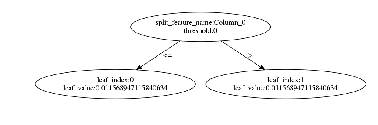

In [9]:
lgb.plot_tree(clf)

In [ ]:
train_columns[48]

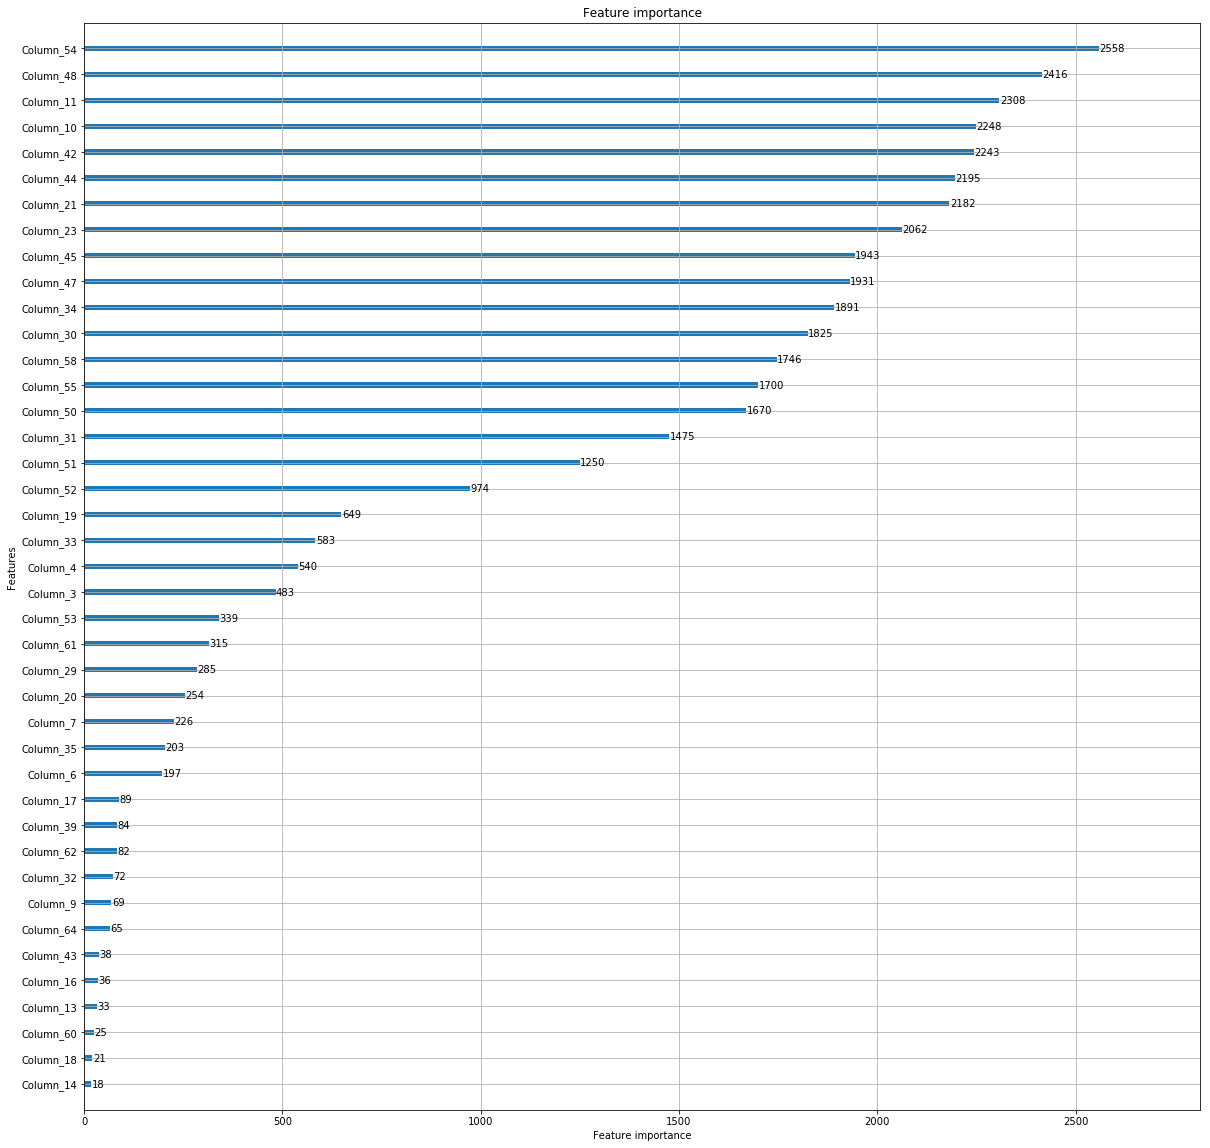

In [10]:
# regionidzip (35), lotsizesquarefeet, structuretaxvaluedollarcnt(45), yearbuilt(43), 
# latitude(22), calculatedfinishedsquarefeet, taxamout(49)
lgb.plot_importance(clf, figsize=(20,20), )

# XGBoost

In [11]:
# data
prop = pd.read_csv('../input/properties_2016.csv')

# feature engineering
prop['prop_age'] = 2018 - prop['yearbuilt']  # property age

prop['total_rm_ct'] = prop['bathroomcnt'] + prop['bedroomcnt']  # total bed rm+ bathrm
prop['room_size_avg'] = prop['calculatedfinishedsquarefeet'] / prop['roomcnt']
prop['tax_structure_land'] = prop['structuretaxvaluedollarcnt'] - prop['landtaxvaluedollarcnt']
prop['living_area_proportion'] = prop['calculatedfinishedsquarefeet'] / prop['lotsizesquarefeet']
prop['living_area_proportion_2'] = prop['finishedsquarefeet12'] / prop['finishedsquarefeet15']

prop["location"] = prop["latitude"] + prop["longitude"]  # location total
# properties within the zip code
prop['homes_wi_zip'] = prop['regionidzip'].map(prop['regionidzip'].value_counts().to_dict())

# one hot
prop['has_basement'] = prop['basementsqft'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop['has_hottub'] = prop['hashottuborspa'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop['has_pool'] = prop['poolcnt'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)
prop['has_ac'] = prop['airconditioningtypeid'].apply(lambda x: 0 if np.isnan(x) else 1).astype(float)

# pre-process
for c in prop.columns:
    prop[c] = prop[c].fillna(-1)
    if prop[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(prop[c].values))
        prop[c] = lbl.transform(list(prop[c].values))

train_df = train.merge(prop, how='left', on='parcelid')
x_train = train_df.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
x_test = prop.drop(['parcelid'], axis=1)
print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

x_train = pd.get_dummies(x_train)  # handle categorical

# drop outliers --important--
train_df = train_df[train_df.logerror > -0.4]
train_df = train_df[train_df.logerror < 0.419]
x_train = train_df.drop(['parcelid', 'logerror', 'transactiondate'], axis=1)
y_train = train_df['logerror'].values.astype(np.float32)
y_mean = np.mean(y_train)

print('(w/o outliers) \nShape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

/home/bss/opt/anaconda3/envs/zillow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape train: (90275, 69)
Shape test: (2985217, 69)
(w/o outliers) 
Shape train: (88528, 69)
Shape test: (2985217, 69)


In [12]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
#df_test = sample.merge(X_test, on='parcelid', how='left')
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

#### XGBOOST Grid Search

Successful notes

* max_depth - suggets 6

* learning rate suggests 0.04

* 'min_child_weight': 5

* subsampling 1.0

In [13]:
# xgb.cv(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds, nfold=5, seed=0, metrics={'mae'}, callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
test = {'max_depth':[6],
       'learning_rate':[0.038, 0.039, 0.04]}

xgb_params = {
    'eta' : 0.04,
    'min_child_weight': 5,
    'max_depth' : 6,
    'subsample' : 0.80,
    'objective' : 'reg:linear',
    'eval_metric' : 'mae',
    'lambda' : 0.8,
    'alpha' : 0.4,
    'base_score' : y_mean,
    'silent' : 1
}

param_test1 = {'max_depth':[6], 'min_child_weight':list(range(1,6,2))}

clf = xgb.XGBRegressor(dict(xgb_params, silent=1))

gs = GridSearchCV(estimator = clf, param_grid = test)
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth={'eta': 0.04, 'min_child_weight': 5, 'max_depth': 6, 'subsample': 0.8, 'objective': 'reg:linear', 'eval_metric': 'mae', 'lambda': 0....0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [6], 'learning_rate': [0.038, 0.039, 0.04]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [15]:
gs.best_params_, gs.best_estimator_, gs.best_score_

({'learning_rate': 0.04, 'max_depth': 6},
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.04, max_delta_step=0,
        max_depth=6, min_child_weight=1, missing=None, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1),
 0.008425347630852897)

In [16]:
# run model

#dtrain = xgb.DMatrix(x_train, y_train)
#dtest = xgb.DMatrix(x_test)

num_boost_rounds = 250 

# training
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

# predict
xgb_pred1 = model.predict(dtest)
print('XGBoost model #1...')
print(pd.DataFrame(xgb_pred1).head())

# second xgboost run
xgb_params = {
    'eta' : 0.033,
    'max_depth' : 6,
    'subsample' : 0.80,
    'objective' : 'reg:linear',
    'eval_metric' : 'mae',
    'base_score' : y_mean,
    'silent' : 1
}
num_boost_rounds = 150

# training
model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

# predict
xgb_pred2 = model.predict(dtest)
print('XGBoost model #2...')
print(pd.DataFrame(xgb_pred2).head())


# Combining xgboost results
xgb_pred = XGB1_WEIGHT*xgb_pred1 + (1-XGB1_WEIGHT)*xgb_pred2
print(pd.DataFrame(xgb_pred).head())

del train_df
del x_train
del x_test
del prop
del dtest
del dtrain
del xgb_pred1
del xgb_pred2
gc.collect()

XGBoost model #1...
          0
0  0.003653
1 -0.005997
2  0.001085
3  0.005294
4  0.004315
XGBoost model #2...
          0
0  0.005982
1  0.007957
2  0.005458
3  0.008243
4  0.002227
          0
0  0.004099
1 -0.003322
2  0.001923
3  0.005860
4  0.003915


445

In [17]:
def MAE(y, y_pred):
    return np.sum([abs(y[i] - y_pred[i]) for i in range(len(y))]) / len(y)
# x_train, y_train
print(MAE(y_test, xgb_pred))

0.0529882428092


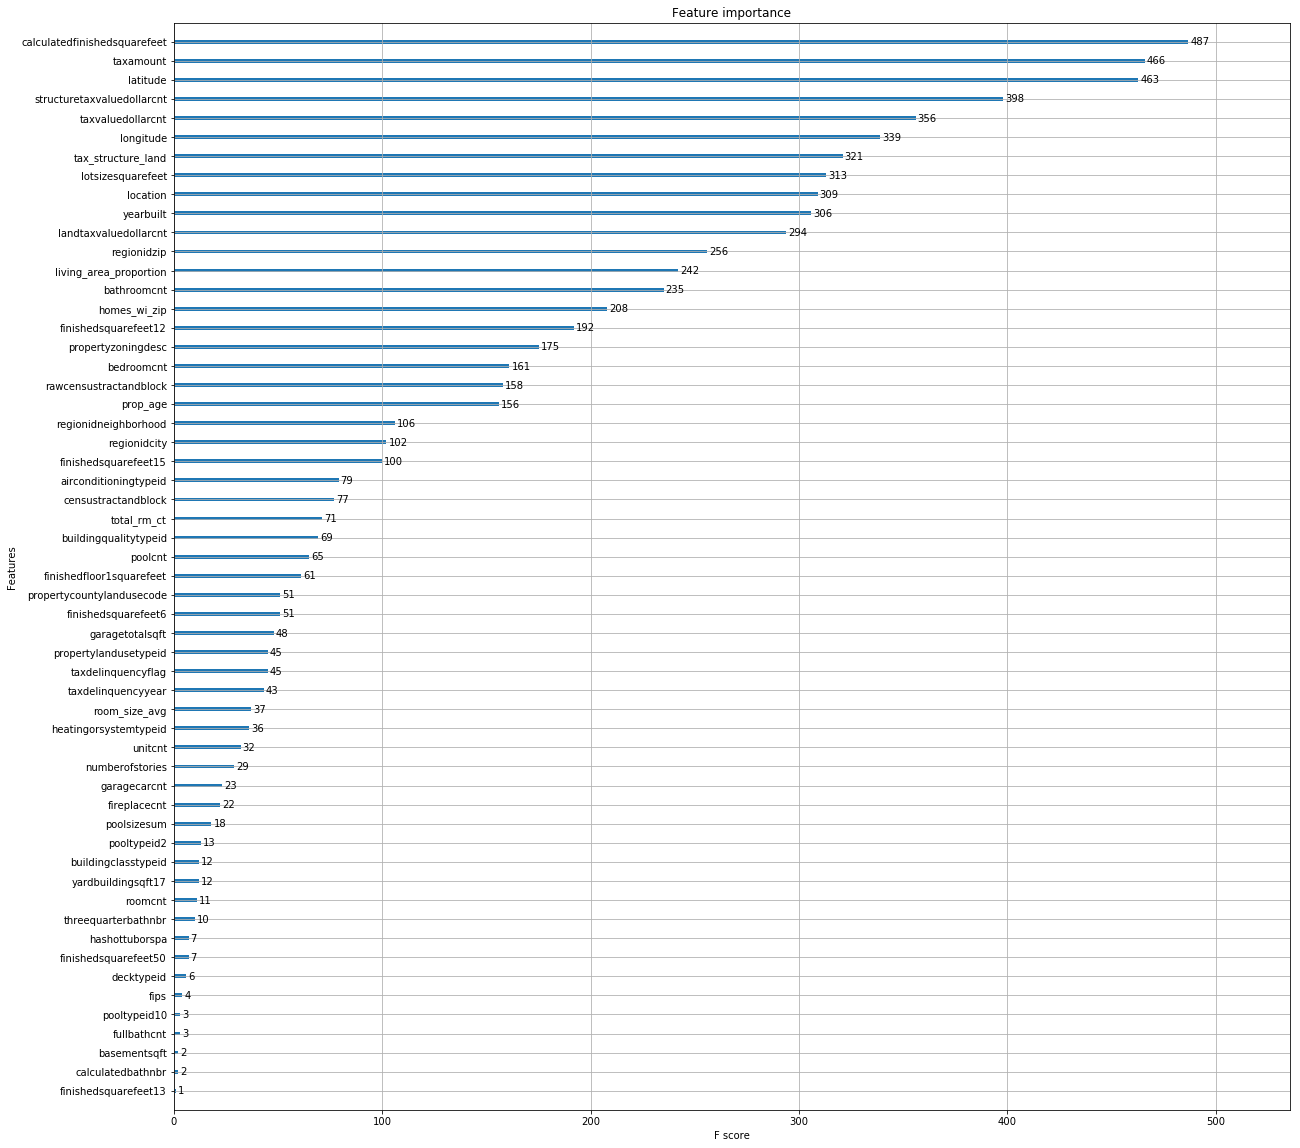

In [18]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(20, 20)

## OLS

This section is untouched -- ignore

In [ ]:
np.random.seed(17)
random.seed(17)

train = pd.read_csv("../input/train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv("../input/properties_2016.csv")
submission = pd.read_csv("../submissions/sample_submission.csv")
print(len(train),len(prop),len(submission))

# feature engineering
prop['prop_age'] = 2018 - prop['yearbuilt']  # property age
prop['total_rm_ct'] = prop['bathroomcnt'] + prop['bedroomcnt']  # total bed rm+ bathrm
prop["location"] = prop["latitude"] + prop["longitude"]  # location total

def get_features(df):
    df["transactiondate"] = pd.to_datetime(df["transactiondate"])
    df["transactiondate_year"] = df["transactiondate"].dt.year
    df["transactiondate_month"] = df["transactiondate"].dt.month
    df['transactiondate'] = df['transactiondate'].dt.quarter
    df = df.fillna(-1.0)
    return df

def MAE(y, ypred):
    #logerror=log(Zestimate)−log(SalePrice)
    return np.sum([abs(y[i]-ypred[i]) for i in range(len(y))]) / len(y)

train = pd.merge(train, prop, how='left', on='parcelid')
y = train['logerror'].values
test = pd.merge(submission, prop, how='left', left_on='ParcelId', right_on='parcelid')
properties = [] #memory

exc = [train.columns[c] for c in range(len(train.columns)) if train.dtypes[c] == 'O'] + ['logerror','parcelid']
col = [c for c in train.columns if c not in exc]

train = get_features(train[col])
test['transactiondate'] = '2016-01-01' #should use the most common training date
test = get_features(test[col])

reg = LinearRegression(n_jobs=-1)
reg.fit(train, y); print('Fitting on ', len(train), ' and ', len(y), ' labels')
print('Predicting on ', len(train))
print(MAE(y, reg.predict(train)))
train = [];  y = [] #memory

test_dates = ['2016-10-01','2016-11-01','2016-12-01','2017-10-01','2017-11-01','2017-12-01']
test_columns = ['201610','201611','201612','201710','201711','201712']

## Combine Predictions

In [ ]:
lgb_weight, xgb_weight0, baseline_weight0

In [ ]:
lgb_weight = (1 - XGB_WEIGHT - BASELINE_WEIGHT) / (1 - OLS_WEIGHT)
xgb_weight0 = XGB_WEIGHT / (1-OLS_WEIGHT)
baseline_weight0 = BASELINE_WEIGHT / (1-OLS_WEIGHT)
pred0 =  xgb_weight0 * xgb_pred +baseline_weight0*BASELINE_PRED + lgb_weight*p_test

print("Combined XGB+LGB+baseline predictions:")
print(pd.DataFrame(pred0).head())

# predicting w/ OLS and combining xgb lgb baseline predictions
for i in range(len(test_dates)):
    test['transactiondate'] = test_dates[i]
    pred = OLS_WEIGHT * reg.predict(get_features(test)) + (1 - OLS_WEIGHT) * pred0
    submission[test_columns[i]] = [float(format(x, '.4f')) for x in pred]
    print('Predict...', i)

print("\nCombined XGB/LGB/baseline/OLS predictions:")
print(submission.head())

## Submission File

In [ ]:
submission.to_csv('../submissions/submission_addFeatures_v2.csv', index=False)

## Resources:

https://www.slideshare.net/odsc/owen-zhangopen-sourcetoolsanddscompetitions1

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/